## Predicting Customer Lifetime Value (CLV) with Personalized Product Recommendations to Optimize Marketing Spend

**Problem Statement**
Many companies invest heavily in customer acquisition and retention without fully understanding the long-term value of each customer. This leads to inefficient marketing strategies, wasted budget, and missed opportunities for retaining high-value customers.

**Solution**

By accurately predicting Customer Lifetime Value (CLV), businesses can:

* Identify High-Value Customers: Focus retention efforts and marketing dollars on customers with high lifetime value.

* Optimize Marketing Spend: Allocate budget proportionally based on expected return on investment (ROI) for each segment.

* Maximize Profitability: Reduce customer churn and increase ROI by targeting the right customers with personalized strategies.

In [1]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00


In [2]:
!pip install arviz pymc_marketing pymc==5.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.25.5
    Uninstalling pytensor-2.25.5:
      Successfully uninstalled pytensor-2.25.5
  Attempting uninstall: pymc
    Found existing installation: pymc 5.16.2
    Uninstalling pymc-5.16.2:
      Successfully uninstalled pymc-5.16.2


In [32]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

import pymc as pm
from pymc_marketing import clv
import arviz as az
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [5]:
data = pd.read_csv('online_retail_II.csv')

# Data Preprocessing

In [7]:
#According to the documentation if the Invoice code starts with the letter 'c', it indicates a cancellation.
Cancelled_Transactions = data[data["Invoice"].str.contains("C", na=False)]
Cancelled_Transactions

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [8]:
# We remove rows where the 'Invoice' contains the letter 'C'
data = data[~data["Invoice"].str.contains("C", na=False)]

In [9]:
data.isna().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,242257
Country,0


In [10]:
# Drop rows where Customer ID is missing (since we need it for CLV calculations)
data = data.dropna(subset=['Customer ID'])
data = data.dropna(subset=['Description'])

In [11]:
# 3. Convert InvoiceDate to a datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [12]:
data['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [13]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [14]:
data[data['Price'] == 0].value_counts().sum()

71

In [15]:
# Remove transactions with negative or zero quantity and price
data = data[data['Price'] > 0]

# Basic EDA

In [16]:
data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,805549.000000,805549,805549.000000,805549.000000
mean,13.290522,2011-01-02 10:24:44.106814464,3.206561,15331.954970
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-07-07 12:08:00,1.250000,13982.000000
50%,5.000000,2010-12-03 15:10:00,1.950000,15271.000000
75%,12.000000,2011-07-28 13:05:00,3.750000,16805.000000
max,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000
std,143.634088,NaN,29.199173,1696.737039


Both the Quantity and Price columns show signs of outliers, as evidenced by their large maximum values relative to the mean and standard deviation.

In [17]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = data[variable].quantile(q1)
    upper_boundary = data[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(data,variable):
    upper_boundary,lower_boundary =  find_boundaries(data,variable)
    data[variable] = np.where(data[variable] > upper_boundary, upper_boundary,
                       np.where(data[variable] < lower_boundary, lower_boundary, data[variable]))

In [18]:
# handle the outlaiers
capping_outliers(data,'Price')
capping_outliers(data,'Quantity')

In [19]:
data["TotalPrice"] = data["Quantity"] * data["Price"]

In [20]:
#filter the data to be only in the uk
data = data[data.Country == 'United Kingdom']

In [21]:
transction_data=data.copy()

In [22]:
# date_format = '%Y/%m/%d %H:%M:%S'
date_format = '%d/%m/%Y %H:%M'
transction_data['InvoiceDate']=pd.to_datetime(transction_data['InvoiceDate'], format= date_format)

In [23]:
transction_data["Transaction Id"]=transction_data.index

,Invoice Count Per Day
InvoiceDateOnly,
2009-12-01,88
2009-12-02,106
2009-12-03,119
2009-12-04,76
2009-12-05,29


<Figure size 1500x700 with 0 Axes>

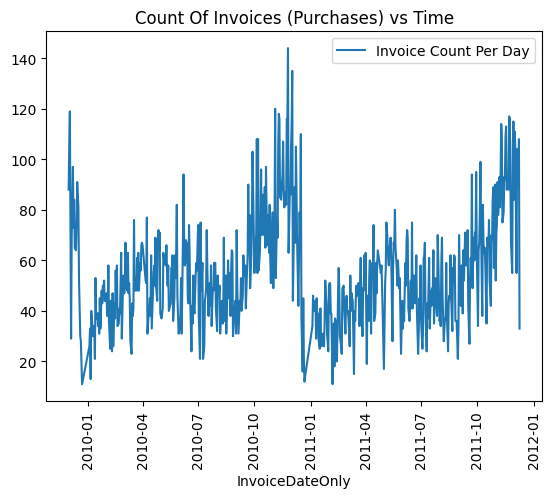

In [26]:
# Create a copy of the original dataframe
transction_data_copy = transction_data.copy()

# Extract the date only from the 'InvoiceDate' column
transction_data_copy['InvoiceDateOnly'] = pd.DatetimeIndex(transction_data_copy['InvoiceDate']).date

# Group by 'InvoiceDateOnly' and count unique invoices per day
Invoice_By_Date = transction_data_copy[["Invoice", "InvoiceDateOnly"]].groupby("InvoiceDateOnly").agg('nunique')

# Rename the column for clarity
Invoice_By_Date = Invoice_By_Date.rename(columns={'Invoice': 'Invoice Count Per Day'})

plt.figure(figsize=(15,7))

# Plot the count of invoices per day
Invoice_By_Date.plot(y="Invoice Count Per Day", kind='line', rot='vertical', title='Count Of Invoices (Purchases) vs Time')

Invoice_By_Date.head()

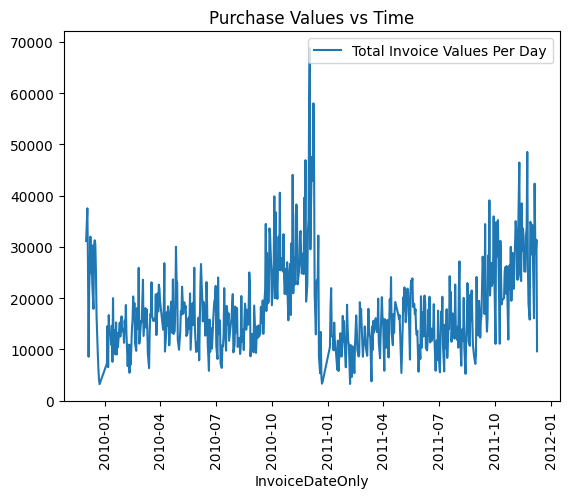

In [27]:
Total_Purchas=transction_data_copy[["InvoiceDateOnly","TotalPrice"]].groupby("InvoiceDateOnly").agg('sum')

Total_Purchas = Total_Purchas.rename(columns={'TotalPrice': 'Total Invoice Values Per Day'})

Total_Purchas.plot(kind='line', rot='vertical',title='Purchase Values vs Time')
plt.show()


<Axes: ylabel='StockCode'>

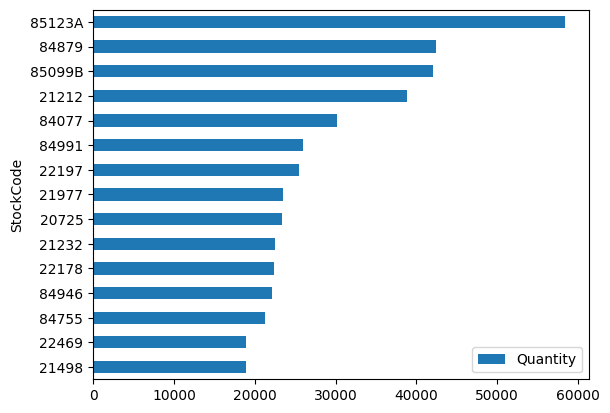

In [28]:
#Top Products By Quantity Purchased
product_quantity = pd.DataFrame(transction_data_copy.groupby("StockCode")["Quantity"].sum())
product_quantity.sort_values("Quantity",ascending=True).tail(15).plot(kind='barh')

<Axes: ylabel='Customer ID'>

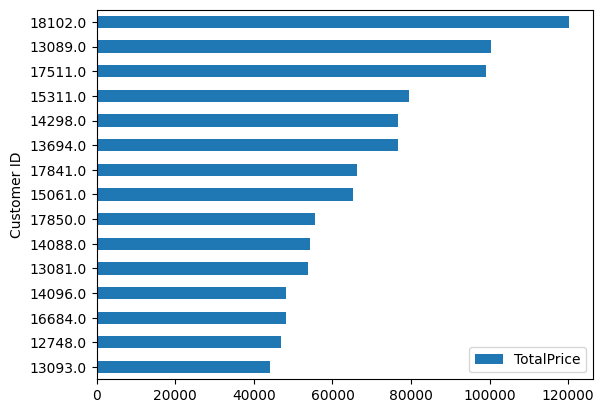

In [31]:
#Top Customers By Spend
customer_spend = pd.DataFrame(transction_data_copy.groupby("Customer ID")['TotalPrice'].sum())
customer_spend.sort_values("TotalPrice",ascending=True).tail(15).plot(kind='barh')

# Train/Test Split

In [33]:
data.shape

(725250, 9)

In [34]:
data=data.sort_values('InvoiceDate')

In [35]:
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

In [36]:
train_min_date=min(train_data['InvoiceDate'])
train_max_date = max(train_data['InvoiceDate'])
display("Training Data Max Date: "+str(train_max_date))
display("Training Data Min Date: "+str(train_min_date))
display("Training Data Total Dur Days: " +str((train_max_date-train_min_date).days))
display("Training Data Total Dur Weeks: " +str(round((train_max_date-train_min_date).days/7,1)))
display("Training Data Total Dur Mths: " +str(round((train_max_date-train_min_date).days/30.417,1)))

'Training Data Max Date: 2011-06-08 16:39:00'

'Training Data Min Date: 2009-12-01 07:45:00'

'Training Data Total Dur Days: 554'

'Training Data Total Dur Weeks: 79.1'

'Training Data Total Dur Mths: 18.2'

In [37]:
max_date=max(data['InvoiceDate'])

In [38]:
calibration_period_end = train_max_date
observation_period_end = max_date
NoOfDaysToPredict = observation_period_end-calibration_period_end

print(NoOfDaysToPredict.days)


183


In [39]:
train_data.describe()

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,507675.000000,507675,507675.000000,507675.000000,507675.000000
mean,8.201536,2010-09-06 07:49:21.509942016,2.774865,15558.003185,15.356388
min,1.000000,2009-12-01 07:45:00,0.420000,12346.000000,0.420000
25%,2.000000,2010-05-06 11:44:00,1.250000,14221.000000,4.250000
50%,4.000000,2010-09-28 14:09:00,1.950000,15570.000000,10.200000
75%,12.000000,2010-12-08 15:38:00,3.750000,16945.000000,17.700000
max,36.000000,2011-06-08 16:39:00,8.500000,18287.000000,306.000000
std,9.214365,NaN,2.287972,1596.932802,19.859524


## Feature engineering(RMF Analysis)

* **Recency** tells us how engaged the customer is.
* **Monetary** Value tells us how valuable the customer is.
* **Frequency** tells us how loyal the customer is.
* **Tenure** helps us understand how stable the customer’s relationship with the business is.

These features are crucial for:
* **CLV Prediction**: They provide a basis for accurately predicting the future value a customer will bring.

* **Personalized Recommendations**: They allow for targeted recommendations that can drive engagement and maximize sales, tailored to different types of customers.

In [40]:
from lifetimes.utils import *
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

RFM_data = calibration_and_holdout_data(data, customer_id_col='Customer ID',
                                                  datetime_col='InvoiceDate',
                                                  monetary_value_col='TotalPrice',
                                                  freq='D',
                                                  freq_multiplier=1,
                                                  include_first_transaction=False,
                                                  datetime_format='%Y/%m/%d %H:%M:%S',calibration_period_end=train_max_date,
                                                  observation_period_end=max_date)


In [41]:
from lifetimes.utils import summary_data_from_transaction_data

def compute_rfm(customer_data, max_date=None):
    if not max_date:
        max_date = customer_data['InvoiceDate'].max()
    rfm = summary_data_from_transaction_data(
        customer_data,
        customer_id_col='Customer ID',
        datetime_col='InvoiceDate',
        monetary_value_col='TotalPrice',
        freq='D',
        freq_multiplier=1,
        include_first_transaction=False,
        datetime_format='%Y/%m/%d %H:%M:%S'
    )
    return rfm


In [42]:
compute_rfm(data)

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,725.0,45.757143
12608.0,0.0,0.0,404.0,0.000000
12745.0,1.0,88.0,574.0,261.130000
12746.0,0.0,0.0,540.0,0.000000
12747.0,25.0,730.0,732.0,335.839600
...,...,...,...,...
18283.0,18.0,655.0,658.0,145.623889
18284.0,0.0,0.0,431.0,0.000000
18285.0,0.0,0.0,660.0,0.000000


In [43]:
RFM_data.sort_values('frequency_cal', ascending=[False])

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Customer ID,,,,,,,
15311.0,149.0,553.0,554.0,414.627450,46.0,15.408997,184.0
14606.0,138.0,551.0,552.0,173.477899,42.0,3.790881,184.0
12748.0,132.0,551.0,551.0,200.693788,69.0,6.365941,184.0
17841.0,126.0,553.0,553.0,301.539524,66.0,4.952321,184.0
13089.0,101.0,552.0,553.0,732.274059,30.0,30.067540,184.0
...,...,...,...,...,...,...,...
16624.0,0.0,0.0,13.0,0.000000,1.0,13.546667,184.0
16622.0,0.0,0.0,359.0,0.000000,0.0,0.000000,184.0
13757.0,0.0,0.0,490.0,0.000000,0.0,0.000000,184.0


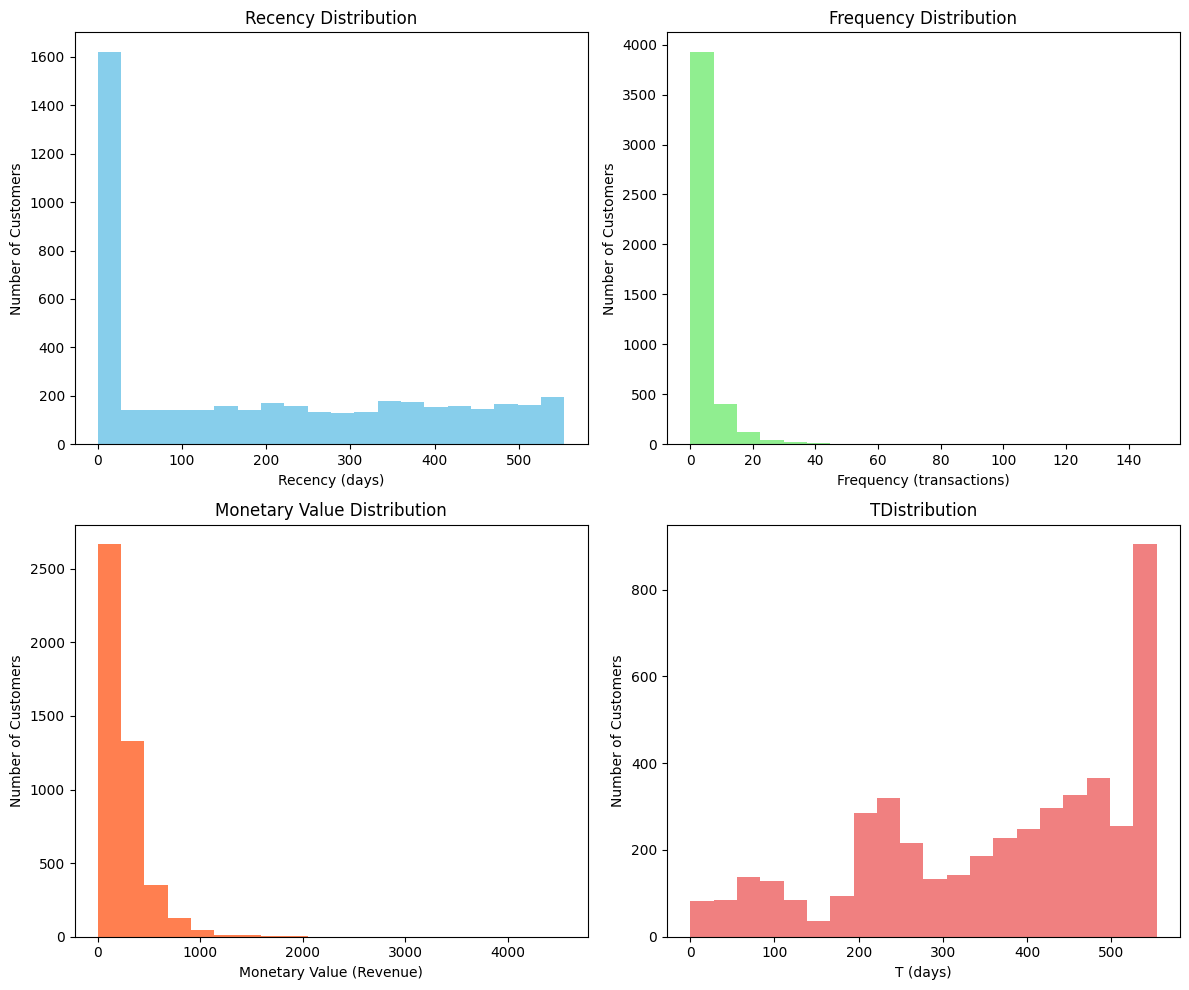

In [44]:
# Create a figure and subplots for each variable
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for Recency
axs[0, 0].hist(RFM_data['recency_cal'], bins=20, color='skyblue')
axs[0, 0].set_title('Recency Distribution')
axs[0, 0].set_xlabel('Recency (days)')
axs[0, 0].set_ylabel('Number of Customers')

# Histogram for Frequency
axs[0, 1].hist(RFM_data['frequency_cal'], bins=20, color='lightgreen')
axs[0, 1].set_title('Frequency Distribution')
axs[0, 1].set_xlabel('Frequency (transactions)')
axs[0, 1].set_ylabel('Number of Customers')

# Histogram for Monetary Value
axs[1, 0].hist(RFM_data['monetary_value_cal'], bins=20, color='coral')
axs[1, 0].set_title('Monetary Value Distribution')
axs[1, 0].set_xlabel('Monetary Value (Revenue)')
axs[1, 0].set_ylabel('Number of Customers')

# Histogram for T
axs[1, 1].hist(RFM_data['T_cal'], bins=20, color='lightcoral')
axs[1, 1].set_title('TDistribution')
axs[1, 1].set_xlabel('T (days)')
axs[1, 1].set_ylabel('Number of Customers')
plt.tight_layout()
plt.show()


# Step 3: BG/NBD Model for CLV Prediction


In [47]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(RFM_data['frequency_cal'],
        RFM_data['recency_cal'],
        RFM_data['T_cal'], )

<lifetimes.BetaGeoFitter: fitted with 4547 subjects, a: 0.17, alpha: 66.12, b: 3.93, r: 0.68>

In [48]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.677835,0.019641,0.639339,0.716332
alpha,66.119675,2.400367,61.414956,70.824394
a,0.172255,0.036485,0.100744,0.243766
b,3.931160,1.216379,1.547057,6.315263


In [50]:
!pip install joblib

In [51]:
import joblib
# Save the model to a file using joblib
joblib.dump(bgf, 'bgf_model.joblib')

['bgf_model.joblib']

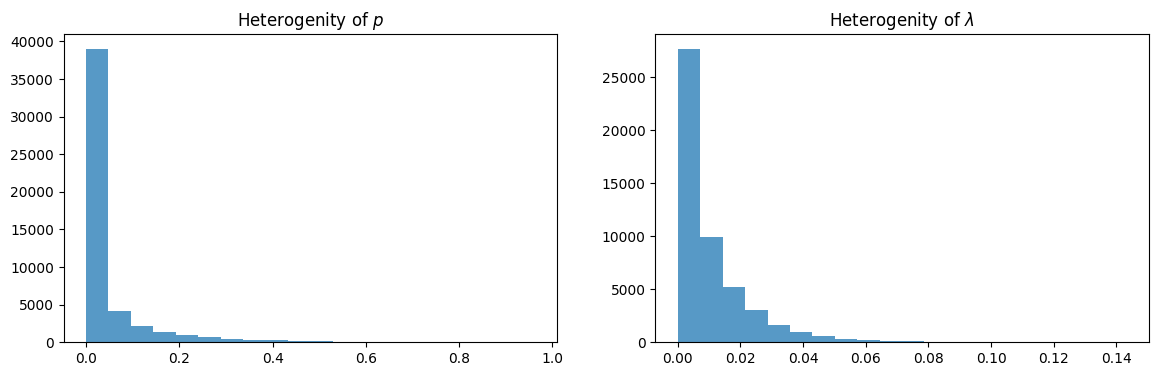

In [52]:
from scipy.stats import beta, gamma
import matplotlib.pyplot as plt

gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, alpha=0.75)
plt.subplot(122)
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 20, alpha=0.75)

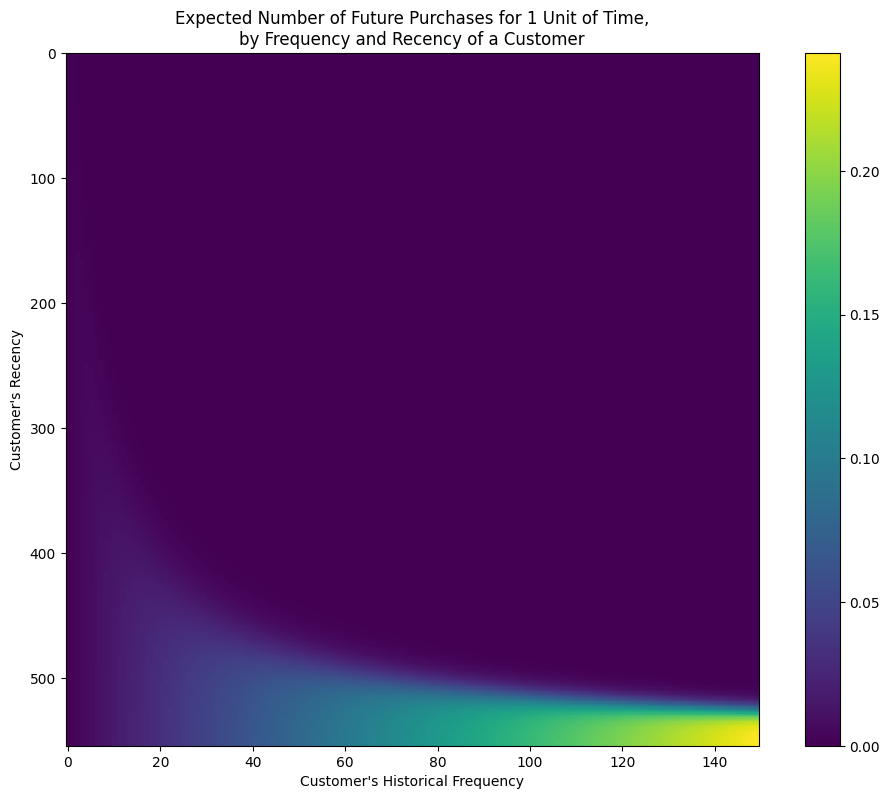

In [53]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

# Customer Probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

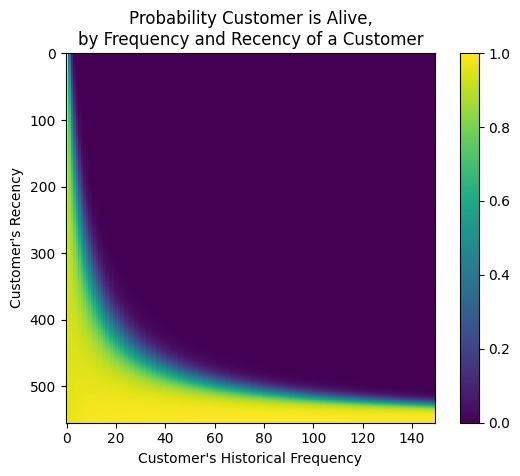

In [54]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Probability of Being Alive for Selected Customers'}, xlabel='Customer ID'>

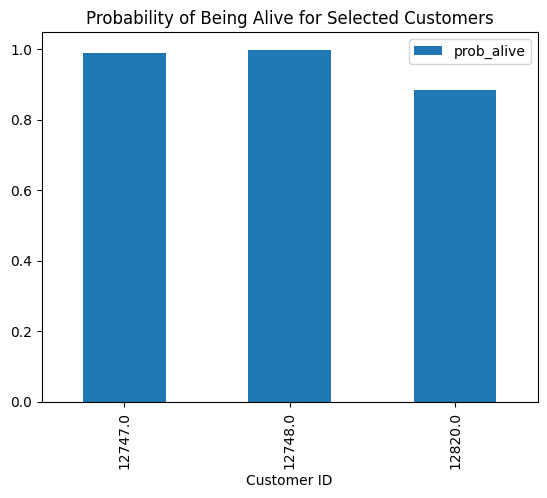

In [55]:
RFM_data['prob_alive'] = bgf.conditional_probability_alive(RFM_data['frequency_cal'], RFM_data['recency_cal'], RFM_data['T_cal'])
selected_customers = RFM_data.loc[[12747.0, 12748.0, 12820.0]]  # customer IDs
selected_customers[['prob_alive']].plot(kind='bar', title='Probability of Being Alive for Selected Customers')

In [56]:
RFM_data.sort_values("frequency_cal",ascending=False)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,prob_alive
Customer ID,,,,,,,,
15311.0,149.0,553.0,554.0,414.627450,46.0,15.408997,184.0,0.998559
14606.0,138.0,551.0,552.0,173.477899,42.0,3.790881,184.0,0.998472
12748.0,132.0,551.0,551.0,200.693788,69.0,6.365941,184.0,0.998725
17841.0,126.0,553.0,553.0,301.539524,66.0,4.952321,184.0,0.998666
13089.0,101.0,552.0,553.0,732.274059,30.0,30.067540,184.0,0.998050
...,...,...,...,...,...,...,...,...
16624.0,0.0,0.0,13.0,0.000000,1.0,13.546667,184.0,1.000000
16622.0,0.0,0.0,359.0,0.000000,0.0,0.000000,184.0,1.000000
13757.0,0.0,0.0,490.0,0.000000,0.0,0.000000,184.0,1.000000


In [57]:
TimeToPredict=NoOfDaysToPredict.days
TimeToPredict

183

In [58]:
RFM_data["Predicted Purchases In HoldOut"] = bgf.predict(t=TimeToPredict,
                                                        frequency=RFM_data['frequency_cal'],
                                                        recency=RFM_data['recency_cal'],
                                                        T=RFM_data['T_cal'])

RFM_data.sort_values("frequency_cal",ascending=False)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,prob_alive,Predicted Purchases In HoldOut
Customer ID,,,,,,,,,
15311.0,149.0,553.0,554.0,414.627450,46.0,15.408997,184.0,0.998559,43.112120
14606.0,138.0,551.0,552.0,173.477899,42.0,3.790881,184.0,0.998472,40.067885
12748.0,132.0,551.0,551.0,200.693788,69.0,6.365941,184.0,0.998725,38.405467
17841.0,126.0,553.0,553.0,301.539524,66.0,4.952321,184.0,0.998666,36.551172
13089.0,101.0,552.0,553.0,732.274059,30.0,30.067540,184.0,0.998050,29.322451
...,...,...,...,...,...,...,...,...,...
16624.0,0.0,0.0,13.0,0.000000,1.0,13.546667,184.0,1.000000,1.476356
16622.0,0.0,0.0,359.0,0.000000,0.0,0.000000,184.0,1.000000,0.287706
13757.0,0.0,0.0,490.0,0.000000,0.0,0.000000,184.0,1.000000,0.220625


In [60]:
#Filtered for Top 10 customers by the higher monetary value who have less than 25% chance of being "alive"
RFM_data[(RFM_data['prob_alive'] <= 0.25)].sort_values("monetary_value_cal",ascending=False).head(10)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,prob_alive,Predicted Purchases In HoldOut
Customer ID,,,,,,,,,
17850.0,22.0,362.0,550.0,2425.599091,0.0,0.0,184.0,0.036239,0.238957
13093.0,42.0,460.0,551.0,1036.173095,0.0,0.0,184.0,0.223625,2.768184
17448.0,17.0,148.0,461.0,839.843529,0.0,0.0,184.0,0.000014,0.000084
14685.0,4.0,150.0,542.0,732.150000,0.0,0.0,184.0,0.241477,0.334227
13564.0,24.0,383.0,553.0,669.928333,1.0,8.5,184.0,0.053669,0.383217
15413.0,4.0,47.0,554.0,602.235000,0.0,0.0,184.0,0.013866,0.018826
15369.0,7.0,239.0,547.0,498.594286,0.0,0.0,184.0,0.213565,0.480392
14025.0,7.0,119.0,399.0,494.590000,0.0,0.0,184.0,0.046572,0.137350
14160.0,6.0,88.0,514.0,441.155000,0.0,0.0,184.0,0.007368,0.015228


## Model Results VS Actual

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

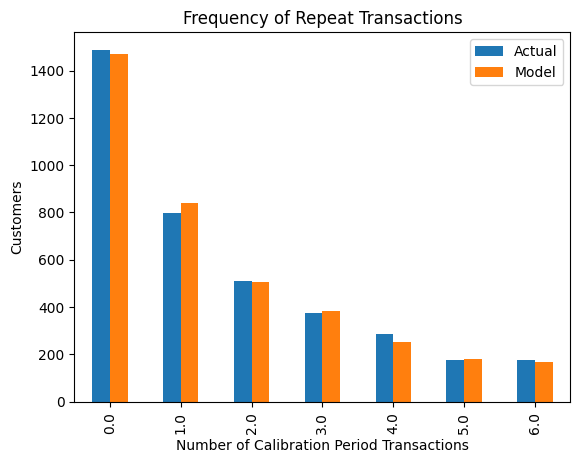

In [61]:
plot_period_transactions(bgf)

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

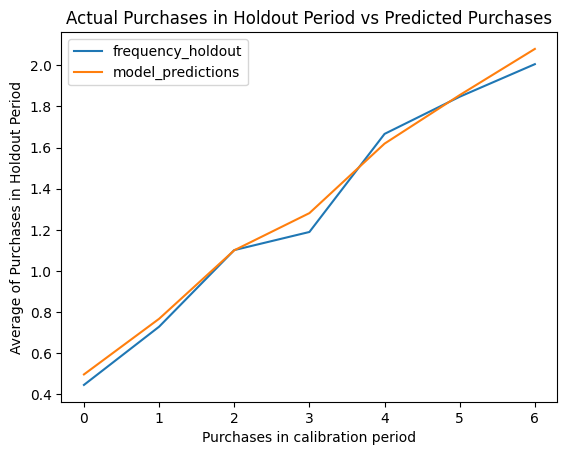

In [62]:
plot_calibration_purchases_vs_holdout_purchases(bgf, RFM_data)

## Ranking customers from best to worst

Having fit the model, we can ask what is the expected number of purchases for our customers in the next period. Let’s look at the four more promising customers.

In [63]:
t = 180 # 6 month
sdata=RFM_data.copy()

In [64]:
sdata['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, RFM_data['frequency_cal'], RFM_data['recency_cal'], RFM_data['T_cal'])
sdata.sort_values(by='expected_purc_6_months').tail(10)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,prob_alive,Predicted Purchases In HoldOut,expected_purc_6_months
Customer ID,,,,,,,,,,
17961.0,67.0,542.0,554.0,36.030149,16.0,4.654157,184.0,0.990841,19.350302,19.039508
13694.0,67.0,543.0,551.0,916.787612,15.0,51.423916,184.0,0.994078,19.505953,19.192686
16422.0,69.0,511.0,512.0,357.357826,22.0,48.760183,184.0,0.997306,21.476517,21.132010
13798.0,74.0,545.0,547.0,447.874595,24.0,53.138523,184.0,0.997150,21.726486,21.377616
14527.0,92.0,553.0,553.0,216.284565,28.0,8.301471,184.0,0.998189,26.731917,26.302645
13089.0,101.0,552.0,553.0,732.274059,30.0,30.067540,184.0,0.998050,29.322451,28.851598
17841.0,126.0,553.0,553.0,301.539524,66.0,4.952321,184.0,0.998666,36.551172,35.964288
12748.0,132.0,551.0,551.0,200.693788,69.0,6.365941,184.0,0.998725,38.405467,37.788854
14606.0,138.0,551.0,552.0,173.477899,42.0,3.790881,184.0,0.998472,40.067885,39.424572


# Estimating Customer Lifetime Value Using the Gamma-Gamma Model

In [66]:
#Gamma-Gamma model assumes at least 1 repeat transaction has been observed per customer.
#As such we filter out those with zero repeat purchases.
nonzero_RFM = RFM_data[RFM_data["frequency_cal"]>0]

In [67]:
#The Gamma-Gamma model relies upon the important assumption there is no relationship between the monetary value and the purchase frequency.
nonzero_RFM[['frequency_cal','monetary_value_cal']].corr()

,frequency_cal,monetary_value_cal
frequency_cal,1.000000,0.133476
monetary_value_cal,0.133476,1.000000


the correlation not strong as a result we can use gammma

In [68]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.1)
ggf.fit(nonzero_RFM['frequency_cal'],
        nonzero_RFM['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 3059 subjects, p: 1.04, q: 0.18, v: 0.94>

In [69]:
# Save the model to a file using joblib
joblib.dump(ggf, 'ggf_model.joblib')

['ggf_model.joblib']

In [70]:
#From docs : this method computes the conditional expectation of the average profit per
#transaction for a group of one or more customers.
monetary_pred = ggf.conditional_expected_average_profit(RFM_data['frequency_holdout'],
                                        RFM_data['monetary_value_holdout'])

In [71]:
RFM_data["Predicted Monetary Value(HoldOut)"]=monetary_pred

RFM_data["Predicted Monetary Value(HoldOut)"]=round(RFM_data["Predicted Monetary Value(HoldOut)"],1)

## Compare BG-NBD+GG Model Predictions Against Test (Holdout) Period

In [72]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",36.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,75.6
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
...,...,...,...,...,...,...,...,...,...
1067340,581585,22726,ALARM CLOCK BAKELIKE GREEN,8.0,2011-12-09 12:31:00,3.75,15804.0,United Kingdom,30.0
1067353,581586,21217,RED RETROSPOT ROUND CAKE TINS,24.0,2011-12-09 12:49:00,8.50,13113.0,United Kingdom,204.0
1067351,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8.0,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.6
1067352,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24.0,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.0


In [73]:
from lifetimes.utils import summary_data_from_transaction_data

FULL_rfm_data = summary_data_from_transaction_data(data,
                                      customer_id_col='Customer ID',datetime_col='InvoiceDate',
                                      monetary_value_col='TotalPrice',freq='D',
                                      freq_multiplier=1,include_first_transaction=False,
                                      datetime_format='%Y/%m/%d %H:%M:%S')

FULL_rfm_data.rename(columns = {'frequency':'frequency_test+train period'}, inplace = True)
FULL_rfm_data=FULL_rfm_data[["frequency_test+train period"]]

sdata = RFM_data.copy()

sdata=sdata.join(FULL_rfm_data)

In [74]:
sdata

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,prob_alive,Predicted Purchases In HoldOut,Predicted Monetary Value(HoldOut),frequency_test+train period
Customer ID,,,,,,,,,,,
12346.0,7.0,400.0,541.0,45.757143,0.0,0.000000,184.0,0.883431,2.006479,-1.2,7.0
12608.0,0.0,0.0,220.0,0.000000,0.0,0.000000,184.0,1.000000,0.424841,-1.2,0.0
12745.0,1.0,88.0,390.0,261.130000,0.0,0.000000,184.0,0.787048,0.521003,-1.2,1.0
12746.0,0.0,0.0,356.0,0.000000,0.0,0.000000,184.0,1.000000,0.289724,-1.2,0.0
12747.0,20.0,534.0,548.0,315.524000,5.0,43.448125,184.0,0.988043,5.960463,51.8,25.0
...,...,...,...,...,...,...,...,...,...,...,...
18283.0,9.0,458.0,474.0,118.358889,9.0,2.969466,184.0,0.981052,3.147646,3.4,18.0
18284.0,0.0,0.0,247.0,0.000000,0.0,0.000000,184.0,1.000000,0.388827,-1.2,0.0
18285.0,0.0,0.0,476.0,0.000000,0.0,0.000000,184.0,1.000000,0.226263,-1.2,0.0


In [75]:
sdata=sdata.drop(["prob_alive",
"Predicted Purchases In HoldOut",
"Predicted Monetary Value(HoldOut)"],axis=1)

In [76]:
sdata["Prob of Alive At End Of Calibration Period"]=RFM_data['prob_alive']
sdata["expected no of purchases in holdout period"]=RFM_data["Predicted Purchases In HoldOut"]
sdata["Predicted Monetary Value for holdOut period"]=RFM_data["Predicted Monetary Value(HoldOut)"]
sdata["actual_no_of_purchases in holdout period"]=sdata["frequency_test+train period"]-sdata["frequency_holdout"]
sdata

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,frequency_test+train period,Prob of Alive At End Of Calibration Period,expected no of purchases in holdout period,Predicted Monetary Value for holdOut period,actual_no_of_purchases in holdout period
Customer ID,,,,,,,,,,,,
12346.0,7.0,400.0,541.0,45.757143,0.0,0.000000,184.0,7.0,0.883431,2.006479,-1.2,7.0
12608.0,0.0,0.0,220.0,0.000000,0.0,0.000000,184.0,0.0,1.000000,0.424841,-1.2,0.0
12745.0,1.0,88.0,390.0,261.130000,0.0,0.000000,184.0,1.0,0.787048,0.521003,-1.2,1.0
12746.0,0.0,0.0,356.0,0.000000,0.0,0.000000,184.0,0.0,1.000000,0.289724,-1.2,0.0
12747.0,20.0,534.0,548.0,315.524000,5.0,43.448125,184.0,25.0,0.988043,5.960463,51.8,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,9.0,458.0,474.0,118.358889,9.0,2.969466,184.0,18.0,0.981052,3.147646,3.4,9.0
18284.0,0.0,0.0,247.0,0.000000,0.0,0.000000,184.0,0.0,1.000000,0.388827,-1.2,0.0
18285.0,0.0,0.0,476.0,0.000000,0.0,0.000000,184.0,0.0,1.000000,0.226263,-1.2,0.0


# Estimating CLV
we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value

In [77]:
#Take full dataset (Calibration PLUS HOLDOUT) and rerun to get RFM characteristics

Full_data = summary_data_from_transaction_data(data,
                                                   customer_id_col='Customer ID',
                                                   datetime_col='InvoiceDate',
                                                   monetary_value_col='TotalPrice',
                                                   datetime_format='%Y/%m/%d %H:%M:%S',
                                                   observation_period_end=None,
                                                   freq='D',
                                                   freq_multiplier=1,
                                                   include_first_transaction=False)

Full_data ["Predicted Probability Of Customer Alive At Start Of Forecast Period"] = bgf.conditional_probability_alive(
                                                                  frequency=Full_data['frequency'],
                                                                  recency=Full_data['recency'],
                                                                  T=Full_data['T']).round(3)


forecastperiod=365 #days

Full_data["Predicted Purchases For Forecast Period"] = bgf.predict(t=forecastperiod,
                                                                  frequency=Full_data['frequency'],
                                                                  recency=Full_data['recency'],
                                                                  T=Full_data['T']).round(2)


#From docs : this method computes the conditional expectation of the average profit per
#transaction for a group of one or more customers.

Full_data["Predicted Monetary Value Per Transaction"] = (ggf.conditional_expected_average_profit(
                                        Full_data['frequency'],
                                        Full_data['monetary_value'])).round(2)

print("Forecast Period= "+str(forecastperiod)+" Days")

Full_data.sort_values("monetary_value", ascending=False)

Forecast Period= 365 Days


,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,Predicted Purchases For Forecast Period,Predicted Monetary Value Per Transaction
Customer ID,,,,,,,
14088.0,13.0,411.0,421.0,3384.122308,0.986,9.65,3602.62
14096.0,16.0,97.0,101.0,3012.454375,0.987,32.29,3168.61
17084.0,1.0,361.0,396.0,2790.980000,0.952,1.22,13181.67
17850.0,22.0,362.0,734.0,2425.599091,0.000,0.00,2515.77
15786.0,3.0,490.0,536.0,2162.426667,0.963,2.08,2933.45
...,...,...,...,...,...,...,...
14946.0,0.0,0.0,14.0,0.000000,1.000,2.80,-1.20
14950.0,0.0,0.0,19.0,0.000000,1.000,2.64,-1.20
14951.0,0.0,0.0,79.0,0.000000,1.000,1.60,-1.20


In [78]:
# refit the BG model to the summary_with_money_value dataset

Full_data["Discounted CLV"]=(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    Full_data['frequency'],
    Full_data['recency'],
    Full_data['T'],
    Full_data['monetary_value'],
    time=12, # months
    discount_rate=0.01,freq="D")).round(2) # monthly discount rate ~ 12.7% annually)

In [79]:
Full_data

,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,Predicted Purchases For Forecast Period,Predicted Monetary Value Per Transaction,Discounted CLV
Customer ID,,,,,,,,
12346.0,7.0,400.0,725.0,45.757143,0.498,1.72,51.72,82.19
12608.0,0.0,0.0,404.0,0.000000,1.000,0.51,-1.20,-0.57
12745.0,1.0,88.0,574.0,261.130000,0.677,0.63,1237.34,724.60
12746.0,0.0,0.0,540.0,0.000000,1.000,0.40,-1.20,-0.44
12747.0,25.0,730.0,732.0,335.839600,0.993,11.30,346.81,3629.45
...,...,...,...,...,...,...,...,...
18283.0,18.0,655.0,658.0,145.623889,0.991,9.02,152.35,1272.87
18284.0,0.0,0.0,431.0,0.000000,1.000,0.49,-1.20,-0.54
18285.0,0.0,0.0,660.0,0.000000,1.000,0.34,-1.20,-0.37


# Generating Synthetic Customer Data

In [80]:
from lifetimes.generate_data import beta_geometric_nbd_model
size=5000

T = 365  # Length of observation (days)
a=0.16
alpha=65.48
b=3.41
r=0.67


p=1.02
q=0.18
v=0.93
x=Full_data["monetary_value"][Full_data["frequency"]>0].mean().round(2)


SyntheticData=beta_geometric_nbd_model(T, r, alpha, a, b, size)

SyntheticData["monetary val"]=(np.random.gamma((p),(np.random.gamma(q,v)),size)*x).round(2)

SyntheticData.sort_values("monetary val",ascending=False)

,frequency,recency,T,lambda,p,alive,monetary val
customer_id,,,,,,,
4950.0,5.0,313.611794,365.0,0.035209,0.010060,1.0,0.03
3625.0,1.0,270.243360,365.0,0.009012,0.010073,1.0,0.03
3528.0,2.0,73.061248,365.0,0.004693,0.170225,0.0,0.03
3359.0,7.0,344.823381,365.0,0.017933,0.000271,1.0,0.03
4039.0,7.0,346.939153,365.0,0.012976,0.006185,1.0,0.03
...,...,...,...,...,...,...,...
1957.0,1.0,349.648060,365.0,0.005494,0.179474,1.0,0.00
1958.0,2.0,173.417690,365.0,0.006569,0.000432,1.0,0.00
1960.0,4.0,354.126791,365.0,0.006575,0.067449,1.0,0.00


# Custmer segmentation

In [81]:
custmer_data=Full_data.copy()

In [82]:
custmer_data=custmer_data.reset_index()

In [83]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

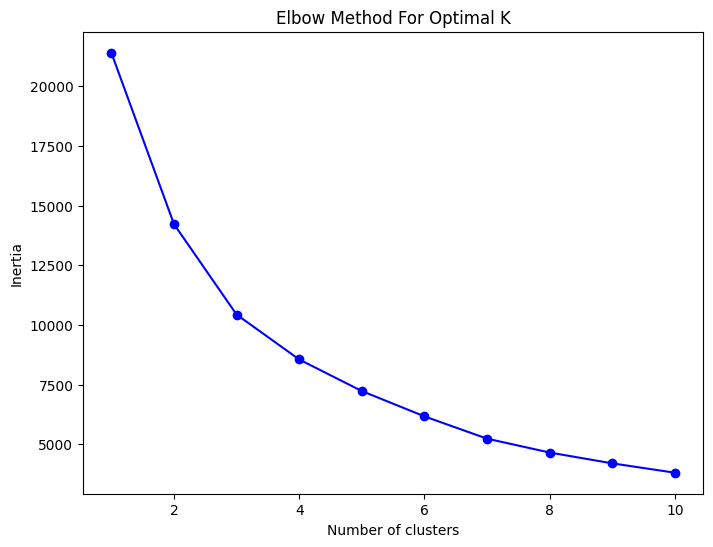

In [84]:
# Step 1: Standardize the features (important for distance-based algorithms like K-means)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(custmer_data[['recency', 'frequency', 'monetary_value', 'Discounted CLV']])

# Step 3: Determine the optimal number of clusters using the Elbow Method
inertia = []  # List to store the inertia values for each number of clusters
K = range(1, 11)  # Trying out cluster values from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph to visualize the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [85]:
# Step 4: Apply K-means with the chosen number of clusters
optimal_k = 3  # optimal number from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the KMeans model
kmeans.fit(scaled_features)

# Save the trained model using joblib
import joblib
joblib.dump(kmeans, 'kmeans_model.joblib')

# Optionally, if you need the cluster labels for current data:
cluster_labels = kmeans.predict(scaled_features)



In [86]:
custmer_data['Segment']=cluster_labels

In [87]:
# Save the model to a file using joblib
joblib.dump(kmeans, 'kmeans_model.joblib')
joblib.dump(scaler, 'scaled_features.joblib')

['scaled_features.joblib']

In [88]:
# Group by the customer segments and analyze the characteristics of each segment
segment_analysis = custmer_data.groupby('Segment').agg({
    'Customer ID':'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean',
    'T': 'mean',
    'Discounted CLV': 'mean'
}).reset_index()
segment_analysis

,Segment,Customer ID,recency,frequency,monetary_value,T,Discounted CLV
0,0,2837,70.419457,0.966514,86.735645,375.497004,482.325823
1,1,42,595.761905,63.642857,969.713606,603.714286,21943.053571
2,2,2471,506.963577,7.840955,372.720716,595.099150,1847.390437


In [89]:
df_segments = pd.DataFrame(segment_analysis)

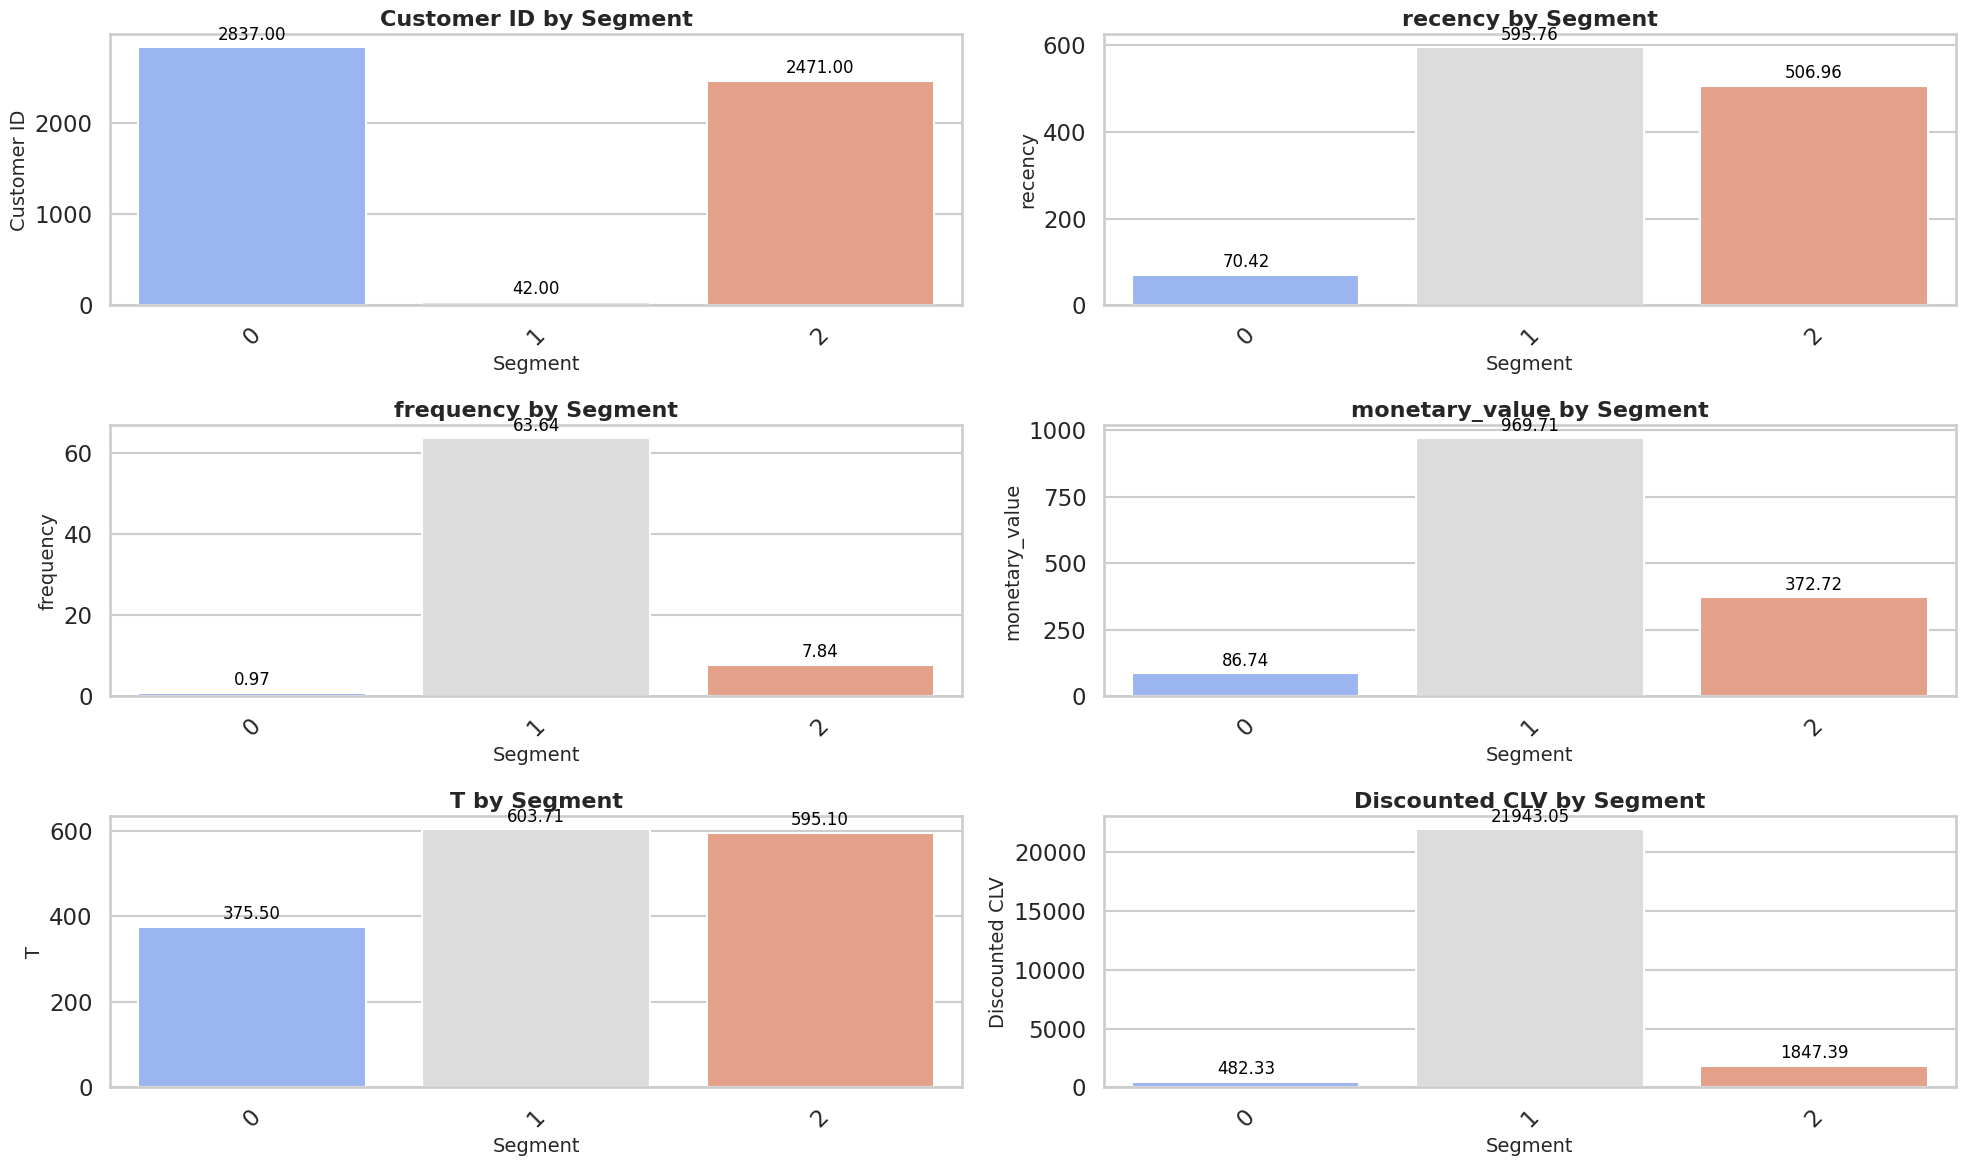

In [91]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid", context="talk")  # Set context for larger labels

# Metrics to visualize
metrics = ['Customer ID', 'recency', 'frequency', 'monetary_value', 'T', 'Discounted CLV']

# Plotting each metric
plt.figure(figsize=(20, 12))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)

    # Create the barplot
    ax = sns.barplot(x='Segment', y=metric, data=df_segments, palette='coolwarm', ci=None)

    # Add value annotations on the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9),
                    textcoords='offset points', fontsize=12, color='black')

    # Titles and labels
    plt.title(f'{metric} by Segment', fontsize=16, fontweight='bold')
    plt.xlabel('Segment', fontsize=14)
    plt.ylabel(metric, fontsize=14)

    # Rotate x-axis labels for clarity if needed
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Segment 0 (Low CLV, Low Engagement and Value)**

* **Characteristics:**  Low recency, low frequency, and monetary value indicate new or inactive customers.

* **action**  Focus on onboarding and re-engagement. The goal is to encourage more activity and increase spending.
* **Strategies**: Personalized offers and best-sellers are great approaches for this segment to reignite interest or nurture new customers.

**Segment 2 (Moderate CLV, Moderate Engagement and Value)**

* **Characteristics:**  Moderate frequency and monetary value, but high recency indicates that these customers may be at risk of churn if not properly engaged.
* **action**  Focus on retention and increasing engagement to prevent churn.
* **Strategies**: Upselling, cross-selling, and bundle offers are effective approaches for these customers. Encouraging higher order values and promoting products related to their past purchases helps retain them and transition them to a higher value segment.

**Segment 1 (High CLV, High Engagement and Value)**

* **Characteristics:**  High frequency, high monetary value, and high recency indicate these are the top-tier customers.
* **action** Retain these customers by maximizing their value and enhancing loyalty.
* **Strategies**: Exclusive offers, early access, and highly personalized recommendations are perfect for these customers. They want to feel valued, and offering them exclusive treatment helps maintain loyalty.

# Recommendation system
 **Segment 0: Low CLV, Low Engagement and Value**

* **Characteristics:** Low recency, frequency, and monetary value.

* **Action:** Onboarding and re-engagement.

* **Strategies**: Personalized offers and best-sellers.

**Segment 1: High CLV, High Engagement and Value**

* **Characteristics**: High recency, frequency, and monetary value.

* **Action:** Retention and loyalty enhancement.

* **Strategies:** Exclusive offers, early access, and highly personalized recommendations.

**Segment 2: Moderate CLV, Moderate Engagement and Value**

* **Characteristics:** Moderate frequency and monetary value, but high recency.

* **Action:** Retention and increasing engagement to prevent churn.

* **Strategies:** Upselling, cross-selling, and bundle offers.

# Data prepreation for recommendation system

In [93]:
#1-prepare the data
transactions_df=data.copy()
segments_df=custmer_data.copy()

In [94]:
# Ensure Customer ID is consistent
transactions_df['Customer ID'] = transactions_df['Customer ID'].astype(int)
segments_df['Customer ID'] = segments_df['Customer ID'].astype(int)

In [95]:
# Merge transaction data with segment data
data_full = transactions_df.merge(segments_df, on='Customer ID')

# Separate data by segments
segment_0 = data_full[data_full['Segment'] == 0]
segment_1 = data_full[data_full['Segment'] == 1]
segment_2 = data_full[data_full['Segment'] == 2]


## Train test split

In [96]:
import pandas as pd
from datetime import timedelta

# Assuming data_full, segment_0, segment_1, segment_2 are already defined

def create_train_test_split(segment_data, test_size=0.2):
    """
    Splits the segment data into training and testing sets based on InvoiceDate.

    Parameters:
    - segment_data: DataFrame for a specific segment.
    - test_size: Proportion of the dataset to include in the test split.

    Returns:
    - train: Training set DataFrame.
    - test: Testing set DataFrame.
    """
    # Convert InvoiceDate to datetime if not already
    segment_data['InvoiceDate'] = pd.to_datetime(segment_data['InvoiceDate'])

    # Sort the data by InvoiceDate
    segment_data_sorted = segment_data.sort_values(by='InvoiceDate')

    # Determine the split point
    split_point = int(len(segment_data_sorted) * (1 - test_size))

    # Split the data
    train = segment_data_sorted.iloc[:split_point]
    test = segment_data_sorted.iloc[split_point:]

    return train, test

# Create train-test splits for each segment
train_0, test_0 = create_train_test_split(segment_0, test_size=0.2)
train_1, test_1 = create_train_test_split(segment_1, test_size=0.2)
train_2, test_2 = create_train_test_split(segment_2, test_size=0.2)


In [97]:
# Concatenate all training data
train_all = pd.concat([train_0, train_1, train_2], ignore_index=True)

# Concatenate all test data
test_all = pd.concat([test_0, test_1, test_2], ignore_index=True)

# Optional: Verify the concatenation
print(f"Total training records: {len(train_all)}")
print(f"Segments distribution:\n{train_all['Segment'].value_counts()}")


Total training records: 580198
Segments distribution:
Segment
2    433541
0     86560
1     60097
Name: count, dtype: int64


In [98]:
def get_actual_purchases(test_data):
    """
    Creates a dictionary mapping Customer ID to a list of their purchased items.
    """
    actual_purchases = test_data.groupby('Customer ID')['Description'].apply(list).to_dict()
    return actual_purchases

# Get actual purchases for all segments
actual_purchases_all = get_actual_purchases(test_all)


In [99]:
# Create a dictionary mapping each user to their actual purchased items in the test set
def get_actual_purchases(test_data):
    """
    Creates a dictionary mapping Customer ID to a list of their purchased items.

    Parameters:
    - test_data: Testing set DataFrame.

    Returns:
    - actual_purchases: Dictionary {Customer ID: [Purchased Items]}
    """
    actual_purchases = test_data.groupby('Customer ID')['Description'].apply(list).to_dict()
    return actual_purchases

# Get actual purchases for each segment's test set
actual_purchases_0 = get_actual_purchases(test_0)
actual_purchases_1 = get_actual_purchases(test_1)
actual_purchases_2 = get_actual_purchases(test_2)


# Segment 0: Personalized offers and best-sellers using Content-Based Filtering

In [101]:
"""# Segment 0: Personalized offers and best-sellers using Content-Based Filtering and Knowledge-Based Systems."""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate best-sellers based on segment data
def recommend_best_sellers(segment_data, top_n=5):
    best_sellers = segment_data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(top_n)
    best_seller_items = best_sellers.index.tolist()
    return best_seller_items

# Function to calculate similar items using TF-IDF for personalized offers
def recommend_similar_items(segment_data, item_description, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    item_matrix = vectorizer.fit_transform(segment_data['Description'].unique())

    # Compute similarity matrix
    similarity = cosine_similarity(item_matrix)

    # Mapping from item to index
    item_to_index = {item: idx for idx, item in enumerate(segment_data['Description'].unique())}
    index_to_item = {idx: item for item, idx in item_to_index.items()}

    # Find similar items
    idx = item_to_index.get(item_description)
    if idx is None:
        return []
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    recommended_items = [index_to_item[i[0]] for i in sim_scores]

    return recommended_items

def combined_recommendation(train_data, user_id, top_n_best_sellers=5, top_n_similar=5):
#Generate combined best-seller and personalized recommendations for a user based on training data.

    # Get the segment for the specific user from training data
    user_data = train_data[train_data['Customer ID'] == user_id]
    if user_data.empty:
        return f"No data found for user ID {user_id}"

    user_segment = user_data['Segment'].iloc[0]

    # Separate data by segment
    segment_data = train_data[train_data['Segment'] == user_segment]

    # Step 1: Recommend best-sellers for this segment
    best_sellers = recommend_best_sellers(segment_data, top_n=top_n_best_sellers)

    # Step 2: Recommend similar items based on a best-seller (e.g., first best-seller)
    if best_sellers:
        sample_item = best_sellers[0]  # Pick the first best-seller for personalized recommendations
        similar_items = recommend_similar_items(segment_data, sample_item, top_n=top_n_similar)
    else:
        similar_items = []

    # Combine both recommendations
    recommendations = {
        'Best-Sellers': best_sellers,
        'Personalized Recommendations (based on similar items)': similar_items
    }

    return recommendations

user_id = 13085  #user ID we want to recommend for
recommendations = combined_recommendation(data_full, user_id)
print(f"Recommendations for User ID {user_id}:", recommendations)

Recommendations for User ID 13085: {'Best-Sellers': ['WHITE HANGING HEART T-LIGHT HOLDER', 'ASSORTED COLOUR BIRD ORNAMENT', 'JUMBO BAG RED RETROSPOT', 'WORLD WAR 2 GLIDERS ASSTD DESIGNS', '60 TEATIME FAIRY CAKE CASES'], 'Personalized Recommendations (based on similar items)': ['PINK HANGING HEART T-LIGHT HOLDER', 'RED HANGING HEART T-LIGHT HOLDER', 'CREAM HANGING HEART T-LIGHT HOLDER', 'HANGING HEART ZINC T-LIGHT HOLDER', 'HEART T-LIGHT HOLDER ']}


# Segment 1: Exclusive offers and highly personalized recommendations using Content-Based and Collaborative Filtering.

## a.Highly Personalized Recommendations: Use detailed user profiles to suggest items.

## b. Exclusive products : Provide access to limited-time or exclusive products.

we will focus on the items that were purchased more recently (closer to 2011) instead of focusing on the entire time span of the dataset. These items could be considered "hot" or recently trending items.

In [102]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Collaborative Filtering Functions
def create_user_item_matrix(segment_data):
    return segment_data.pivot_table(index='Customer ID', columns='Description', values='Quantity', fill_value=0)

def apply_svd(user_item_matrix, n_components=100, random_state=42):
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    return svd.fit_transform(user_item_matrix)

def compute_user_similarity(latent_matrix):
    return cosine_similarity(latent_matrix)

def recommend_collaborative(user_id, user_item_matrix, user_similarity, segment_data, top_n=5):
    if user_id not in user_item_matrix.index:
        return []
    user_idx = user_item_matrix.index.get_loc(user_id)
    sim_scores = list(enumerate(user_similarity[user_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    similar_users = [user_item_matrix.index[i[0]] for i in sim_scores]
    recommended_items = segment_data[segment_data['Customer ID'].isin(similar_users)]['Description'].value_counts().head(top_n).index.tolist()
    return recommended_items

# Exclusive Products Functions
def identify_recently_purchased_items(transactions_df, date_column, recent_days=90):
    transactions_df[date_column] = pd.to_datetime(transactions_df[date_column], errors='coerce')
    most_recent_date = transactions_df[date_column].max()
    recent_purchases = transactions_df[transactions_df[date_column] >= (most_recent_date - pd.Timedelta(days=recent_days))]
    recent_purchases_count = recent_purchases['Description'].value_counts().reset_index()
    recent_purchases_count.columns = ['Description', 'Popularity']
    return recent_purchases_count

def get_customer_purchase_history(segment_data, customer_id):
    customer_data = segment_data[segment_data['Customer ID'] == customer_id]
    return customer_data['Description'].unique().tolist()

def recommend_recent_items(segment_data, customer_id, recent_items_df, top_n=5):
    customer_history = get_customer_purchase_history(segment_data, customer_id)
    recommended_items = recent_items_df[~recent_items_df['Description'].isin(customer_history)]
    return recommended_items.head(top_n)['Description'].tolist()

# Combined Recommendation Function using train data
def combined_recommendation_segment1(train_data, transactions_df, user_id, top_n_collab=5, top_n_recent=5, recent_days=90, n_components=100):

    # Collaborative Filtering Setup (using train data)
    user_item_matrix = create_user_item_matrix(train_1)
    latent_matrix = apply_svd(user_item_matrix, n_components=n_components)
    user_similarity = compute_user_similarity(latent_matrix)

    # Collaborative Recommendations
    collab_recommendations = recommend_collaborative(user_id, user_item_matrix, user_similarity, train_1, top_n=top_n_collab)

    # Exclusive Products Setup (using train data for recent purchases)
    recent_items_df = identify_recently_purchased_items(transactions_df, 'InvoiceDate', recent_days=recent_days)

    if recent_items_df.empty:
        recent_recommendations = []
    else:
        recent_recommendations = recommend_recent_items(train_1, user_id, recent_items_df, top_n=top_n_recent)

    # Combine Recommendations
    combined_recs = {
        'Collaborative Recommendations': collab_recommendations,
        'Exclusive Product Recommendations': recent_recommendations
    }

    return combined_recs

if __name__ == "__main__":

    user_id = 13078
    recommendations = combined_recommendation_segment1(train_data, transactions_df, user_id)
    print(f"Combined Recommendations for Customer {user_id}:", recommendations)


Combined Recommendations for Customer 13078: {'Collaborative Recommendations': ['WHITE HANGING HEART T-LIGHT HOLDER', 'ASSORTED COLOUR BIRD ORNAMENT', 'WOOD BLACK BOARD ANT WHITE FINISH', 'NO SINGING METAL SIGN', 'HAND OVER THE CHOCOLATE   SIGN '], 'Exclusive Product Recommendations': ["PAPER CHAIN KIT 50'S CHRISTMAS ", 'HOT WATER BOTTLE KEEP CALM', 'RABBIT NIGHT LIGHT', 'WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT']}


# Segment 2: Upselling, cross-selling using Association Rule-Based Systems and Collaborative Filtering.

In [103]:
!pip install efficient_apriori

In [108]:
"""# Segment 2: Upselling, cross-selling using Association Rule-Based Systems and Collaborative Filtering."""

from efficient_apriori import apriori as efficient_apriori
from collections import defaultdict

# -------------------------------
# Cross-Selling Functions
# -------------------------------

def get_last_purchased_item(segment_data, customer_id):
    """
    Returns the last purchased item for the given customer based on the InvoiceDate.
    """
    customer_data = segment_data[segment_data['Customer ID'] == customer_id].sort_values(by='InvoiceDate', ascending=False)
    if not customer_data.empty:
        return customer_data.iloc[0]['Description']
    else:
        return None

def preprocess_rules(rules):
    """
    Preprocess association rules into a dictionary for faster lookup.
    Key: item in LHS
    Value: list of items in RHS sorted by confidence and lift
    """
    rule_dict = defaultdict(list)
    for rule in rules:
        for lhs_item in rule.lhs:
            rule_dict[lhs_item].append((list(rule.rhs), rule.confidence, rule.lift))

    # Sort the recommendations in each list by confidence and then by lift
    for lhs_item in rule_dict:
        rule_dict[lhs_item] = sorted(rule_dict[lhs_item], key=lambda x: (x[1], x[2]), reverse=True)

    return rule_dict

def recommend_cross_sell(purchased_item, rule_dict, top_n=5):
    """
    Recommend cross-sell items based on preprocessed association rules.
    """
    recommendations = []
    if purchased_item in rule_dict:
        for rhs, confidence, lift in rule_dict[purchased_item]:
            recommendations.extend(rhs)
            if len(recommendations) >= top_n:
                break
    # Remove duplicates and the purchased_item itself
    recommendations = [item for item in recommendations if item != purchased_item]
    return list(dict.fromkeys(recommendations))[:top_n]

# -------------------------------
# Upselling Functions
# -------------------------------

def recommend_upsell(purchased_item, transactions_df, top_n=3, sort_by='Quantity', ascending=False):
    """
    Recommends higher-priced and popular items for upselling.

    Parameters:
    - sort_by: Column to sort the items for upselling. Default is 'Quantity'.
    - ascending: Sort order. For popularity, typically descending order.
    """
    # Get unique prices for the purchased item
    item_prices = transactions_df[transactions_df['Description'] == purchased_item]['Price'].unique()
    if len(item_prices) == 0:
        return []
    item_price = item_prices.max()  # Assuming max price if multiple exist

    # Find higher-priced items
    higher_priced_items_df = transactions_df[transactions_df['Price'] > item_price]

    if higher_priced_items_df.empty:
        return []

    # Aggregate popularity (e.g., total Quantity sold)
    higher_priced_popularity = higher_priced_items_df.groupby('Description')['Quantity'].sum().reset_index()

    # Sort by specified criteria
    if sort_by in higher_priced_popularity.columns:
        higher_priced_popularity = higher_priced_popularity.sort_values(by=sort_by, ascending=ascending)

    # Recommend top N higher-priced and popular items
    recommended_items = higher_priced_popularity.head(top_n)['Description'].tolist()

    return recommended_items

# -------------------------------
# Combined Recommendation Function for Segment 2
# -------------------------------

def combined_recommendation_segment2(segment_2, transactions_df, customer_id, top_n_cross_sell=5, top_n_upsell=3, min_support=0.02, min_confidence=0.4):
    """
    Generate combined cross-selling and upselling recommendations for Segment 2.
    """
    # Step 1: Get the last purchased item
    last_purchased_item = get_last_purchased_item(segment_2, customer_id)

    if not last_purchased_item:
        print(f"No purchases found for customer {customer_id}")
        return {
            ' ': [],
            ' ': []
        }

    print(f"Last item purchased by customer {customer_id} {last_purchased_item}")

    # Step 2: Filter to top N items but ensure the last purchased item is included
    top_n_items = segment_2['Description'].value_counts().nlargest(5000).index
    if last_purchased_item not in top_n_items:
        top_n_items = top_n_items.append(pd.Index([last_purchased_item]))
    segment_2_filtered = segment_2[segment_2['Description'].isin(top_n_items)]

    # Step 3: Create a list of transactions
    transactions = segment_2_filtered.groupby('Invoice')['Description'].apply(list).tolist()

    # Step 4: Dynamically adjust support and confidence based on number of transactions
    num_transactions = len(transactions)
    if num_transactions < 50:
        min_support = 0.01
        min_confidence = 0.2
    elif num_transactions < 100:
        min_support = 0.015
        min_confidence = 0.3

    # Apply efficient Apriori with dynamic thresholds
    itemsets, rules_efficient = efficient_apriori(transactions, min_support=min_support, min_confidence=min_confidence)

    # Step 5: Preprocess rules for efficient lookup
    rule_dict = preprocess_rules(rules_efficient)

    # Step 6: Get cross-sell recommendations
    cross_sell_recs = recommend_cross_sell(last_purchased_item, rule_dict, top_n=top_n_cross_sell)

    # Step 7: Get upsell recommendations
    upsell_recs = recommend_upsell(last_purchased_item, transactions_df, top_n=top_n_upsell, sort_by='Quantity', ascending=False)

    return {
        ' cross sell recommendation': cross_sell_recs,
        ' upsell recommendation': upsell_recs
    }


if __name__ == "__main__":


    customer_id = 15804

    # Generate Recommendations for Segment 2
    recommendations = combined_recommendation_segment2(
        segment_2=segment_2,
        transactions_df=transactions_df,
        customer_id=customer_id,
        top_n_cross_sell=5,
        top_n_upsell=3,
        min_support=0.02,
        min_confidence=0.4
    )

    #print(f"\n ")
    for key, recs in recommendations.items():
        print(f"{key}: {recs}")


Last item purchased by customer 15804 ALARM CLOCK BAKELIKE GREEN
 cross sell recommendation: ['ALARM CLOCK BAKELIKE RED ']
 upsell recommendation: ['REGENCY CAKESTAND 3 TIER', 'VINTAGE UNION JACK BUNTING', 'RED RETROSPOT CAKE STAND']


In [109]:
data_full2=data_full.drop('Discounted CLV', axis=1)

In [112]:
""" function that takes a customer ID and returns recommendations based on their segment."""

def combined_recommendation(
    train_data,
    transactions_df,
    user_id,
    top_n_best_sellers=5,
    top_n_similar=5,
    top_n_collab=5,
    top_n_cross_sell=5,
    top_n_upsell=3,
    recent_days=90,
    n_components=100,
    min_support=0.02,
    min_confidence=0.4
):

    user_data = train_data[train_data['Customer ID'] == user_id]
    if user_data.empty:
        return {
            'Recommendations': [],
            'Message': f"No data found for user ID {user_id}"
        }

    user_segment = user_data['Segment'].iloc[0]
    segment_data = train_data[train_data['Segment'] == user_segment]

    recommendations = {}

    if user_segment == 0:
        # Segment 0: Best-Sellers and Personalized Recommendations
        best_sellers = recommend_best_sellers(segment_data, top_n=top_n_best_sellers)
        if best_sellers:
            sample_item = best_sellers[0]
            similar_items = recommend_similar_items(segment_data, sample_item, top_n=top_n_similar)
        else:
            similar_items = []
        recommendations = {
            'Best-Sellers': best_sellers,
            'Personalized Recommendations': similar_items
        }

    elif user_segment == 1:
        # Segment 1: Collaborative Filtering and Exclusive Product Recommendations
        # Collaborative Filtering
        user_item_matrix = create_user_item_matrix(segment_data)
        latent_matrix = apply_svd(user_item_matrix, n_components=n_components)
        user_similarity = compute_user_similarity(latent_matrix)
        collab_recommendations = recommend_collaborative(user_id, user_item_matrix, user_similarity, segment_data, top_n=top_n_collab)

        # Exclusive Product Recommendations (Cross-Sell and Upsell)
        recent_items_df = identify_recently_purchased_items(transactions_df, 'InvoiceDate', recent_days=recent_days)
        if recent_items_df.empty:
            recent_recommendations = []
        else:
            recent_recommendations = recommend_recent_items(segment_data, user_id, recent_items_df, top_n=top_n_cross_sell)

        # Upsell Recommendations
        # Assuming the user's last purchased item for upselling
        last_purchased_item = get_last_purchased_item(segment_data, user_id)
        if last_purchased_item:
            upsell_recs = recommend_upsell(last_purchased_item, transactions_df, top_n=top_n_upsell)
        else:
            upsell_recs = []

        recommendations = {
            'Collaborative Recommendations': collab_recommendations,
            'Exclusive Product Recommendations': recent_recommendations,
            'Upsell Recommendations': upsell_recs
        }

    elif user_segment == 2:
        # Segment 2: Cross-Sell and Upsell Recommendations Using Apriori
        cross_sell_recs = []
        upsell_recs = []

        # Cross-Sell Recommendations
        cross_sell_recs = []
        upsell_recs = []
        cross_sell_recs = []

        # Ensure that the customer has made purchases
        last_purchased_item = get_last_purchased_item(segment_data, user_id)
        if last_purchased_item:
            cross_sell_recs = recommend_cross_sell(last_purchased_item, preprocess_rules(efficient_apriori(
                transactions_df.groupby('Invoice')['Description'].apply(list).tolist(),
                min_support=min_support,
                min_confidence=min_confidence
            )[1]), top_n=top_n_cross_sell)
            upsell_recs = recommend_upsell(last_purchased_item, transactions_df, top_n=top_n_upsell)
        else:
            print(f"No purchases found for customer {user_id}")

        recommendations = {
            'Cross-Sell Recommendations': cross_sell_recs,
            'Upsell Recommendations': upsell_recs
        }

    else:
        recommendations = {
            'Recommendations': [],
            'Message': f"Unknown segment {user_segment} for user ID {user_id}"
        }

    return recommendations

if __name__ == "__main__":
    # Ensure that 'train_all' and 'transactions_df' are correctly defined and loaded
    user_id = 17592  # Replace with the actual Customer ID you want to recommend for

    recommendations = combined_recommendation(
        train_data=train_all,
        transactions_df=transactions_df,
        user_id=user_id,
        top_n_similar=3,
        top_n_collab=3,
        top_n_cross_sell=3,
        top_n_upsell=3,
        recent_days=90,
        n_components=100,
        min_support=0.02,
        min_confidence=0.4
    )

    print(f"\nRecommendations for User ID {user_id}:")
    for rec_type, rec_items in recommendations.items():
        print(f"{rec_type}: {rec_items}")




Recommendations for User ID 17592:
Best-Sellers: ['WHITE HANGING HEART T-LIGHT HOLDER', 'WORLD WAR 2 GLIDERS ASSTD DESIGNS', 'ASSORTED COLOUR BIRD ORNAMENT', '60 TEATIME FAIRY CAKE CASES', 'STRAWBERRY CERAMIC TRINKET BOX']
Personalized Recommendations: ['RED HANGING HEART T-LIGHT HOLDER', 'HEART T-LIGHT HOLDER', 'HEART T-LIGHT HOLDER ']
